In [17]:
# Tutorial: https://www.kaggle.com/code/kanncaa1/pytorch-tutorial-for-deep-learning-lovers

In [1]:
# Import Libraries
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# !kaggle competitions download -c digit-recognizer
# !unzip digit-recognizer.zip

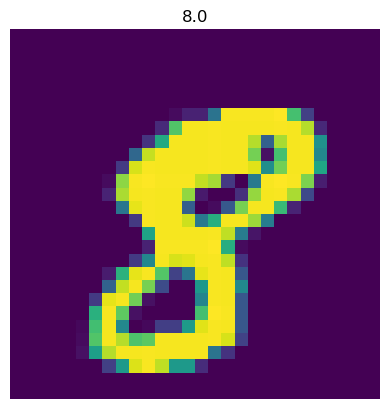

In [3]:
# Prepare Dataset
# load data
train = pd.read_csv(r"./input/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_test, targets_train, targets_test = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 

# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test, batch_size = batch_size, shuffle = False)

# visualize one of the images in data set
plt.imshow(features_numpy[10].reshape(28,28))
plt.axis("off")
plt.title(str(targets_numpy[10]))
plt.savefig('graph.png')
plt.show()

In [4]:
# Create Logistic Regression Model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        # Linear part
        self.linear = nn.Linear(input_dim, output_dim)
        # There should be logistic function right?
        # However logistic function in pytorch is in loss function
        # So actually we do not forget to put it, it is only at next parts
    
    def forward(self, x):
        out = self.linear(x)
        return out

# Instantiate Model Class
input_dim = 28*28 # size of image px*px
output_dim = 10  # labels 0,1,2,3,4,5,6,7,8,9

# create logistic regression model
model = LogisticRegressionModel(input_dim, output_dim)

# Cross Entropy Loss  
error = nn.CrossEntropyLoss()

# SGD Optimizer 
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [5]:
# Traning the Model
count = 0
loss_list = []
iteration_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        # Define variables
        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and cross entropy loss
        loss = error(outputs, labels)
        
        # Calculate gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        # Prediction
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader: 
                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {}%'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 1.8401280641555786  Accuracy: 66.97618865966797%
Iteration: 1000  Loss: 1.6063116788864136  Accuracy: 75.46428680419922%
Iteration: 1500  Loss: 1.2899523973464966  Accuracy: 78.33333587646484%
Iteration: 2000  Loss: 1.1998130083084106  Accuracy: 79.47618865966797%
Iteration: 2500  Loss: 1.0472748279571533  Accuracy: 80.61904907226562%
Iteration: 3000  Loss: 0.9386016130447388  Accuracy: 81.4047622680664%
Iteration: 3500  Loss: 0.9163239002227783  Accuracy: 82.13095092773438%
Iteration: 4000  Loss: 0.747025728225708  Accuracy: 82.82142639160156%
Iteration: 4500  Loss: 0.9713228344917297  Accuracy: 83.26190185546875%
Iteration: 5000  Loss: 0.8077930212020874  Accuracy: 83.5952377319336%
Iteration: 5500  Loss: 0.7509838938713074  Accuracy: 83.96428680419922%
Iteration: 6000  Loss: 0.882637083530426  Accuracy: 84.29762268066406%
Iteration: 6500  Loss: 0.658494770526886  Accuracy: 84.5952377319336%
Iteration: 7000  Loss: 0.7155701518058777  Accuracy: 84.9047622680664%


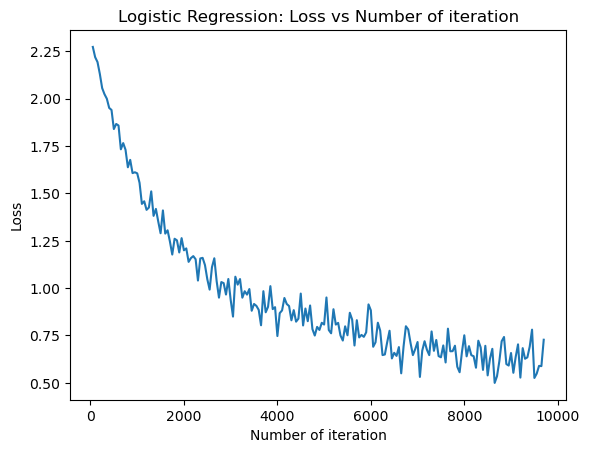

In [6]:
# visualization
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression: Loss vs Number of iteration")
plt.show()

In [7]:
# Next step: Artificial Neural Network (ANN)
# Logistic regression is good at classification but when complexity(non linearity) increases, the accuracy of model decreases.
# Therefore, we need to increase complexity of model.

In [8]:
# Create ANN Model
class ANNModel(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()
        
        # Linear function 1: 784 --> 150
        self.fc1 = nn.Linear(input_dim, hidden_dim) 
        # Non-linearity 1
        self.relu1 = nn.ReLU()
        
        # Linear function 2: 150 --> 150
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2
        self.tanh2 = nn.Tanh()
        
        # Linear function 3: 150 --> 150
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3
        self.elu3 = nn.ELU()
        
        # Linear function 4 (readout): 150 --> 10
        self.fc4 = nn.Linear(hidden_dim, output_dim)  
    
    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)
        
        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)
        
        # Linear function 2
        out = self.fc3(out)
        # Non-linearity 2
        out = self.elu3(out)
        
        # Linear function 4 (readout)
        out = self.fc4(out)
        return out

# instantiate ANN
input_dim = 28*28
hidden_dim = 150 #hidden layer dim is one of the hyper parameter and it should be chosen and tuned. For now I only say 150 there is no reason.
output_dim = 10

# Create ANN
model = ANNModel(input_dim, hidden_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [9]:
# ANN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 28*28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Predict test dataset
            for images, labels in test_loader:

                test = Variable(images.view(-1, 28*28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)

                # Total correct predictions
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.7646658420562744  Accuracy: 79.82142639160156 %
Iteration: 1000  Loss: 0.4425937533378601  Accuracy: 87.61904907226562 %
Iteration: 1500  Loss: 0.24422359466552734  Accuracy: 89.44047546386719 %
Iteration: 2000  Loss: 0.2965471148490906  Accuracy: 90.5952377319336 %
Iteration: 2500  Loss: 0.33152538537979126  Accuracy: 91.95237731933594 %
Iteration: 3000  Loss: 0.11963344365358353  Accuracy: 92.69047546386719 %
Iteration: 3500  Loss: 0.25247135758399963  Accuracy: 93.30952453613281 %
Iteration: 4000  Loss: 0.06286749243736267  Accuracy: 93.86904907226562 %
Iteration: 4500  Loss: 0.3201925754547119  Accuracy: 94.4047622680664 %
Iteration: 5000  Loss: 0.10438115149736404  Accuracy: 94.71428680419922 %
Iteration: 5500  Loss: 0.19196464121341705  Accuracy: 94.9047622680664 %
Iteration: 6000  Loss: 0.17495888471603394  Accuracy: 94.94047546386719 %
Iteration: 6500  Loss: 0.10968174040317535  Accuracy: 95.33333587646484 %
Iteration: 7000  Loss: 0.12706483900547028  Ac

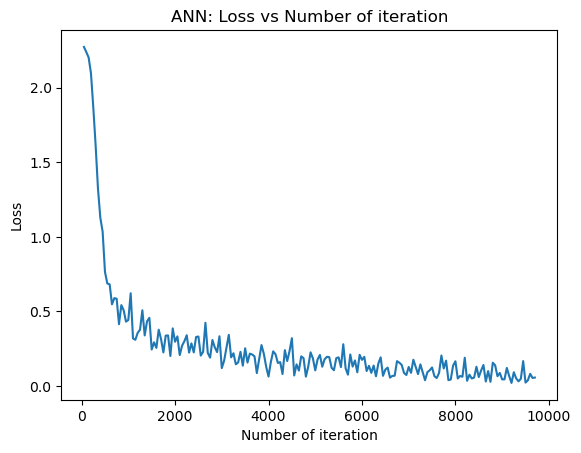

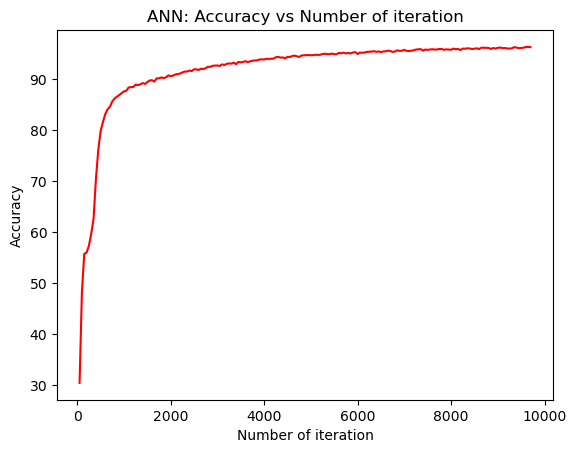

In [10]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

In [11]:
# Next step: Convolutional Neural Network (CNN)

In [12]:
# Create CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()
        
        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
     
        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()
        
        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected 1
        self.fc1 = nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)
        
        # Max pool 1
        out = self.maxpool1(out)
        
        # Convolution 2 
        out = self.cnn2(out)
        out = self.relu2(out)
        
        # Max pool 2 
        out = self.maxpool2(out)
        
        # flatten
        out = out.view(out.size(0), -1)

        # Linear function (readout)
        out = self.fc1(out)
        
        return out

# batch_size, epoch and iteration
batch_size = 100
n_iters = 2500
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and test sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)
    
# Create CNN
model = CNNModel()

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
# CNN model training
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
                
                test = Variable(images.view(100,1,28,28))
                
                # Forward propagation
                outputs = model(test)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += len(labels)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        if count % 500 == 0:
            # Print Loss
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))

Iteration: 500  Loss: 0.10020194202661514  Accuracy: 96.58333587646484 %
Iteration: 1000  Loss: 0.04192883521318436  Accuracy: 97.6547622680664 %
Iteration: 1500  Loss: 0.03123779594898224  Accuracy: 97.78571319580078 %
Iteration: 2000  Loss: 0.01716783083975315  Accuracy: 98.28571319580078 %


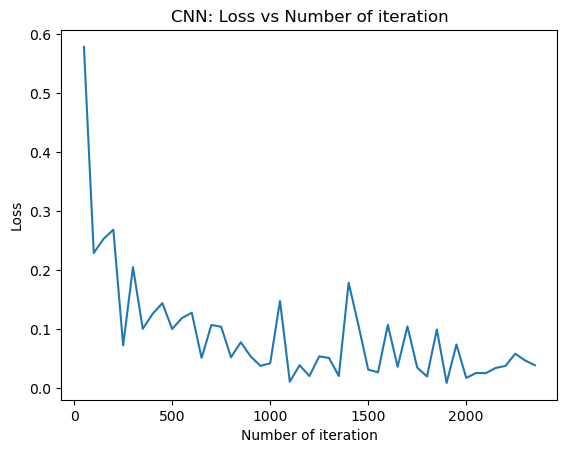

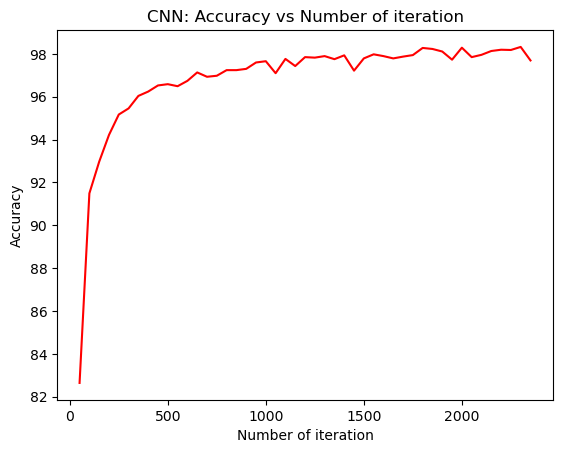

In [14]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()